In [11]:
#spacy
import spacy
from spacy.pipeline import EntityRuler
from spacy.lang.en import English
from spacy.tokens import Doc

#gensim
import gensim
from gensim import corpora

#Visualization
from spacy import displacy
import pyLDAvis.gensim_models
from wordcloud import WordCloud
import plotly.express as px
import matplotlib.pyplot as plt

#Data loading/ Data manipulation
import pandas as pd
import numpy as np
import jsonlines

#nltk
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download(['stopwords','wordnet'])

import ipywidgets as widgets
from IPython.display import display

#warning
import warnings 
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\dhru2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\dhru2\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
df = pd.read_csv("Resume\Resume.csv")
df = df.reindex(np.random.permutation(df.index))
data = df.copy().iloc[
    0:200,
]
data.head()

,ID,Resume_str,Resume_html,Category
1260,14209965,CONTRACT SENIOR ASSOCIATE MEDIA PLANN...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA
1993,19364677,FACILITIES DESIGN AND CONSTRUCTION PR...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION
1093,28139742,SALES ASSOCIATE Summary Cu...,"<div class=""fontsize fontface vmargins hmargin...",SALES
876,27397245,STORE MANAGER Career Overvi...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS


In [3]:
nlp = spacy.load("en_core_web_lg")
skill_pattern_path = "jz_skill_patterns.jsonl"

In [4]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

In [5]:
def get_skills(text):
    doc = nlp(text)
    myset = []
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    myset.append(subset)
    return subset


def unique_skills(x):
    return list(set(x))

In [6]:
clean = []
for i in range(data.shape[0]):
    review = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        data["Resume_str"].iloc[i],
    )
    review = review.lower()
    review = review.split()
    lm = WordNetLemmatizer()
    review = [
        lm.lemmatize(word)
        for word in review
        if not word in set(stopwords.words("english"))
    ]
    review = " ".join(review)
    clean.append(review)

In [7]:
data["Clean_Resume"] = clean
data["skills"] = data["Clean_Resume"].str.lower().apply(get_skills)
data["skills"] = data["skills"].apply(unique_skills)
data.head()

,ID,Resume_str,Resume_html,Category,Clean_Resume,skills
1260,14209965,CONTRACT SENIOR ASSOCIATE MEDIA PLANN...,"<div class=""fontsize fontface vmargins hmargin...",DIGITAL-MEDIA,contract senior associate medium planner sapie...,"[finance, support, workflow, marketing, softwa..."
1993,19364677,FACILITIES DESIGN AND CONSTRUCTION PR...,"<div class=""fontsize fontface vmargins hmargin...",CONSTRUCTION,facility design construction project manager s...,"[support, schedule, design, business, document..."
2476,29534737,PRODUCTION SUPERVISOR / VALUE STREAM ...,"<div class=""fontsize fontface vmargins hmargin...",AVIATION,production supervisor value stream leader summ...,"[schedule, design, engineering, testing, colla..."
1093,28139742,SALES ASSOCIATE Summary Cu...,"<div class=""fontsize fontface vmargins hmargin...",SALES,sale associate summary customer focused manage...,"[wireless, data integrity, business administra..."
876,27397245,STORE MANAGER Career Overvi...,"<div class=""fontsize fontface vmargins hmargin...",FITNESS,store manager career overview highly enthusias...,[passenger]


In [8]:
fig = px.histogram(
    data, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

In [9]:
Job_cat = data["Category"].unique()
Job_cat = np.append(Job_cat, "ALL")

In [23]:
Job_Category = "ALL"  # Initialize Job_Category as a global variable

def update_dropdown_options(data):
    unique_values = data['Category'].unique()
    dropdown.options = unique_values

def handle_dropdown_change(change):
    global Job_Category 
    Job_Category = change['new']
    print("Selected Category:", Job_Category)
    # Use the selected category for further processing
    # For example:
    # filtered_df = df[df['Category'] == selected_category]
    # Do something with the filtered DataFrame

    Total_skills = []
    if Job_Category != "ALL":
        fltr = data[data["Category"] == Job_Category]["skills"]
        for x in fltr:
            for i in x:
                Total_skills.append(i)
    else:
        fltr = data["skills"]
        for x in fltr:
            for i in x:
                Total_skills.append(i)

    fig = px.histogram(
        x=Total_skills,
        labels={"x": "Skills"},
        title=f"{Job_Category} Distribution of Skills",
    ).update_xaxes(categoryorder="total descending")
    fig.show()

dropdown = widgets.Dropdown(options=data['Category'].unique(), description='Category:')
dropdown.observe(handle_dropdown_change, names='value')

display(dropdown)



Dropdown(description='Category:', options=('DIGITAL-MEDIA', 'CONSTRUCTION', 'AVIATION', 'SALES', 'FITNESS', 'D…

Selected Category: INFORMATION-TECHNOLOGY


'INFORMATION-TECHNOLOGY'

Text(0.5, 1.0, 'Most Used Words in INFORMATION-TECHNOLOGY Resume')

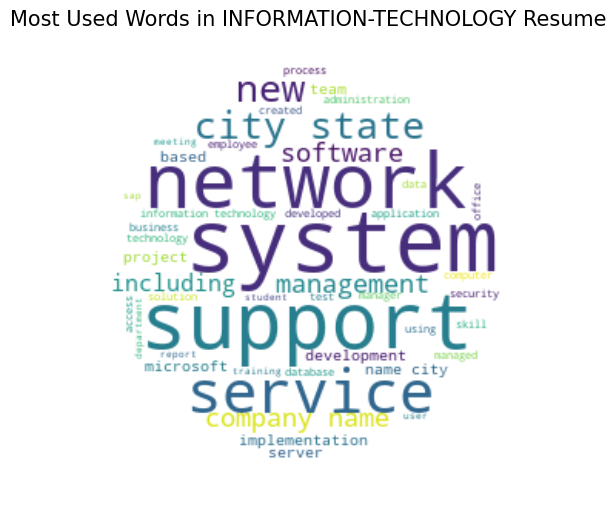

In [32]:
text = ""
for i in data[data["Category"] == Job_Category]["Clean_Resume"].values:
    text += i + " "

plt.figure(figsize=(6, 6))

x, y = np.ogrid[:300, :300]

mask = (x - 150) ** 2 + (y - 150) ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(
    width=400,
    height=400,
    background_color="white",
    min_font_size=6,
    repeat=True,
    mask=mask,
)
wc.generate(text)

plt.axis("off")
plt.imshow(wc, interpolation="bilinear")
plt.title(f"Most Used Words in {Job_Category} Resume", fontsize=15)

In [33]:
sent = nlp(data["Resume_str"].iloc[0])
displacy.render(sent, style="ent", jupyter=True)

In [34]:
displacy.render(sent[0:10], style="dep", jupyter=True, options={"distance": 90})

In [35]:
patterns = df.Category.unique()
for a in patterns:
    ruler.add_patterns([{"label": "Job-Category", "pattern": a}])
    

In [36]:
# options=[{"ents": "Job-Category", "colors": "#ff3232"},{"ents": "SKILL", "colors": "#56c426"}]
colors = {
    "Job-Category": "linear-gradient(90deg, #aa9cfc, #fc9ce7)",
    "SKILL": "linear-gradient(90deg, #9BE15D, #00E3AE)",
    "ORG": "#ffd966",
    "PERSON": "#e06666",
    "GPE": "#9fc5e8",
    "DATE": "#c27ba0",
    "ORDINAL": "#674ea7",
    "PRODUCT": "#f9cb9c",
}
options = {
    "ents": [
        "Job-Category",
        "SKILL",
        "ORG",
        "PERSON",
        "GPE",
        "DATE",
        "ORDINAL",
        "PRODUCT",
    ],
    "colors": colors,
}
sent = nlp(data["Resume_str"].iloc[5])
displacy.render(sent, style="ent", jupyter=True, options=options)

In [40]:
resume_textarea = widgets.Textarea(
    placeholder='Enter your resume here',
    description='Resume:'
)

display(resume_textarea)


Textarea(value='', description='Resume:', placeholder='Enter your resume here')

In [41]:
resume = resume_textarea.value
sent2 = nlp(resume)
displacy.render(sent2, style="ent", jupyter=True, options=options)

In [42]:
skill_text = widgets.Textarea(
    placeholder='Enter skills here',
    description='Skills:'
)

display(skill_text)

Textarea(value='', description='Skills:', placeholder='Enter skills here')

In [45]:
req_skills = skill_text.value.lower().split(",")
resume_skills = unique_skills(get_skills(resume.lower()))
score = 0
for x in req_skills:
    if x in resume_skills:
        score += 1
req_skills_len = len(req_skills)
match = round(score / req_skills_len * 100, 1)

print(f"Match Rate to skillset: {match}%.")

Match Rate to skillset: 83.3%.


In [47]:
docs = data["Clean_Resume"].values
dictionary = corpora.Dictionary(d.split() for d in docs)
bow = [dictionary.doc2bow(d.split()) for d in docs]
lda = gensim.models.ldamodel.LdaModel
num_topics = 4
ldamodel = lda(
    bow, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=50, 
    minimum_probability=0
)
ldamodel.print_topics(num_topics=num_topics)


[(0,
  '0.016*"marketing" + 0.015*"sale" + 0.010*"company" + 0.009*"business" + 0.009*"state" + 0.009*"city" + 0.009*"client" + 0.008*"development" + 0.008*"name" + 0.007*"medium"'),
 (1,
  '0.014*"system" + 0.008*"management" + 0.007*"company" + 0.007*"city" + 0.006*"state" + 0.006*"team" + 0.006*"support" + 0.006*"project" + 0.006*"service" + 0.005*"data"'),
 (2,
  '0.013*"state" + 0.012*"student" + 0.011*"city" + 0.010*"project" + 0.009*"company" + 0.007*"name" + 0.006*"skill" + 0.006*"design" + 0.006*"school" + 0.005*"teacher"'),
 (3,
  '0.011*"company" + 0.011*"state" + 0.010*"city" + 0.010*"customer" + 0.008*"service" + 0.008*"name" + 0.008*"management" + 0.006*"skill" + 0.005*"employee" + 0.005*"office"')]

In [48]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(ldamodel, bow, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.041236 -0.030451       1        1  47.944652
1     -0.055086 -0.090665       2        1  18.440883
2      0.098108  0.035457       3        1  18.027588
0     -0.084257  0.085659       4        1  15.586878, topic_info=            Term        Freq       Total Category  logprob  loglift
202    marketing  372.000000  372.000000  Default  30.0000  30.0000
314         sale  607.000000  607.000000  Default  29.0000  29.0000
608       system  535.000000  535.000000  Default  28.0000  28.0000
1015     student  347.000000  347.000000  Default  27.0000  27.0000
280      project  526.000000  526.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
150   experience   69.997098  419.427528   Topic4  -5.6151   0.0683
274      process   66.491745  421.496157   Topic4  -5.6665   0.0120
592      service   73.707500  692.871313   Topic4  -5.5634  -0.3820
331        skill   65.607020  618.350029   Topic4  -5.6799  -0.3846
279      program   56.386791  351.253069   Topic4  -5.8313   0.0295

[343 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
2464      1  0.242719       access
2464      2  0.667477       access
2464      3  0.091020       access
22        1  0.602887      account
22        2  0.134792      account
...     ...       ...          ...
622       1  0.549880         work
622       2  0.162828         work
622       3  0.181514         work
622       4  0.106773         work
3971      2  0.871127  workstation

[641 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 3, 1])